Epoch   20: Train RMSE=2009.3717 Val RMSE=1909.5601 LR=5.00e-05
Epoch   40: Train RMSE=1665.7249 Val RMSE=1673.7079 LR=5.00e-05
Epoch   60: Train RMSE=1571.9402 Val RMSE=1539.1042 LR=5.00e-05
Epoch   80: Train RMSE=1499.5869 Val RMSE=1549.4494 LR=5.00e-05
Epoch  100: Train RMSE=954.7240 Val RMSE=1068.6344 LR=2.50e-05
Epoch  120: Train RMSE=892.7065 Val RMSE=1009.9588 LR=2.50e-05
Epoch  140: Train RMSE=871.4548 Val RMSE=969.6566 LR=2.50e-05
Epoch  160: Train RMSE=783.7350 Val RMSE=887.5297 LR=2.50e-05
Epoch  180: Train RMSE=708.6888 Val RMSE=909.6931 LR=2.50e-05
Epoch  200: Train RMSE=1858.5817 Val RMSE=1900.0297 LR=1.25e-05
Epoch  220: Train RMSE=1071.9747 Val RMSE=1166.4101 LR=1.25e-05
Epoch  240: Train RMSE=714.8746 Val RMSE=877.3935 LR=1.25e-05
Epoch  260: Train RMSE=648.4818 Val RMSE=821.8714 LR=1.25e-05
Epoch  280: Train RMSE=666.2672 Val RMSE=830.6815 LR=1.25e-05
Epoch  300: Train RMSE=867.0136 Val RMSE=978.7287 LR=6.25e-06
Epoch  320: Train RMSE=615.2027 Val RMSE=800.2770 LR=6.2

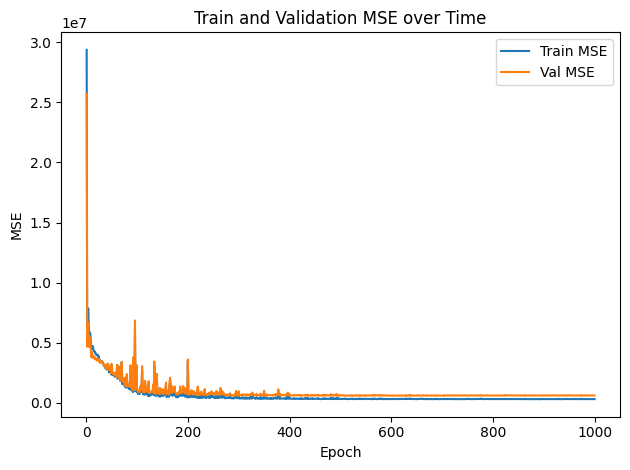

In [29]:
import math
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from gnn_dataset_generation import PolymerDataset
from torch_geometric.nn import GINConv, global_add_pool
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU
from torch.optim.lr_scheduler import StepLR

dataset = PolymerDataset(root='.')
train_idx, val_idx = train_test_split(
    list(range(len(dataset))), test_size=0.2, random_state=42
)
train_subset = torch.utils.data.Subset(dataset, train_idx)
val_subset = torch.utils.data.Subset(dataset, val_idx)

train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=1)


class GIN(torch.nn.Module):
    """Graph Isomorphism Network with ReLU activations."""

    def __init__(self, in_dim, hidden_dim):
        """Initialize GINConv layers and linear heads.

        Args:
            in_dim: Dimension of node features.
            hidden_dim: Dimension of hidden layers.
        """
        super().__init__()
        def make_nn(in_f):
            return Sequential(
                Linear(in_f, hidden_dim),
                BatchNorm1d(hidden_dim),
                ReLU(),
                Linear(hidden_dim, hidden_dim),
                ReLU(),
            )
        self.conv1 = GINConv(make_nn(in_dim))
        self.conv2 = GINConv(make_nn(hidden_dim))
        self.conv3 = GINConv(make_nn(hidden_dim))
        self.lin1 = Linear(hidden_dim, hidden_dim)
        self.lin2 = Linear(hidden_dim, 1)

    def forward(self, data):
        """Compute forward pass and return per-graph positive predictions.

        Args:
            data: Batch from DataLoader with x, edge_index, batch.

        Returns:
            Tensor of shape [num_graphs].
        """
        x, edge_index, batch = data.x, data.edge_index, data.batch
        h = self.conv1(x, edge_index).relu()
        h = self.conv2(h, edge_index).relu()
        h = self.conv3(h, edge_index)
        h = global_add_pool(h, batch)
        h = self.lin1(h).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        out = self.lin2(h)
        return out.view(-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GIN(in_dim=3, hidden_dim=128).to(device)
optimizer = torch.optim.Adam(
    model.parameters(), lr=5e-5, weight_decay=5e-4
)
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

train_targets = torch.tensor(
    [train_subset[i].y.view(-1)[0].item()
     for i in range(len(train_subset))],
    dtype=torch.float32
)
mean = train_targets.mean().to(device)
std = train_targets.std().clamp(min=1e-6).to(device)


def train_epoch():
    """Run one training epoch."""
    model.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        y = data.y.view(data.num_graphs, -1)[:, 0]
        loss = F.mse_loss((out * std + mean - y) / std,
                          torch.zeros_like(out))
        loss.backward()
        optimizer.step()


def compute_mse(loader):
    """Compute mean squared error over the given loader.

    Args:
        loader: DataLoader for evaluation.

    Returns:
        Mean squared error (float).
    """
    model.eval()
    total_sq = 0.0
    total_n = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data) * std + mean
            y = data.y.view(data.num_graphs, -1)[:, 0]
            total_sq += ((out - y) ** 2).sum().item()
            total_n += data.num_graphs
    return total_sq / total_n


n_epochs = 1000
train_mse_list = []
val_mse_list = []

for epoch in range(1, n_epochs + 1):
    train_epoch()
    scheduler.step()
    train_mse = compute_mse(train_loader)
    val_mse = compute_mse(val_loader)
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)

    if epoch % 20 == 0:
        train_rmse = math.sqrt(train_mse)
        val_rmse = math.sqrt(val_mse)
        print(f'Epoch {epoch:4d}: Train RMSE={train_rmse:.4f} '
              f'Val RMSE={val_rmse:.4f} '
              f'LR={scheduler.get_last_lr()[0]:.2e}')

plt.figure()
plt.plot(range(1, n_epochs + 1), train_mse_list, label='Train MSE')
plt.plot(range(1, n_epochs + 1), val_mse_list, label='Val MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Train and Validation MSE over Time')
plt.legend()
plt.tight_layout()
plt.savefig('mse_over_time.png', dpi=300)
plt.show()